In [43]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

from kalman_experiments.kalman import ColoredMeasurementNoiseKF
from kalman_experiments.gen_ar_noise import ArNoise

<IPython.core.display.Javascript object>


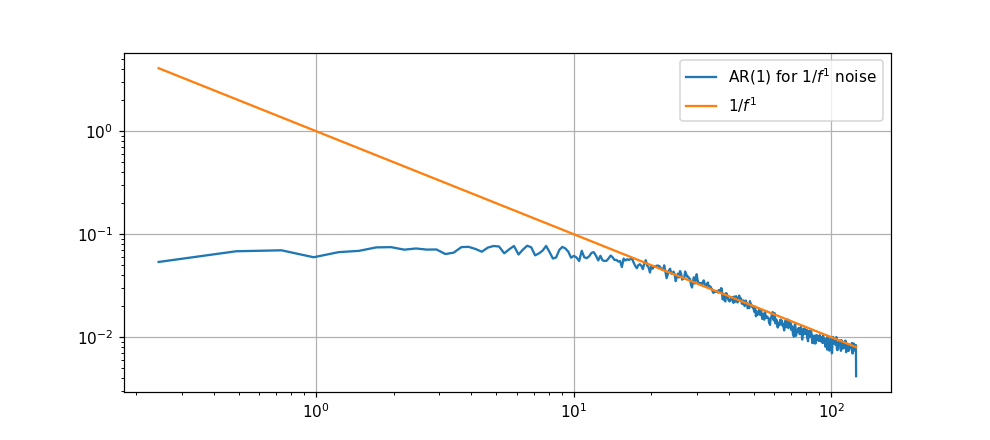

In [76]:
noise_ar_order, alpha, sigma = 1, 1, 1.5
an = ArNoise(y0=np.random.rand(noise_ar_order), alpha=alpha, order=noise_ar_order, sigma=sigma)
res = np.array([an.step() for _ in range(100_000)])
freqs, psd = welch(res, fs=250, nperseg=1024)

plt.figure(figsize=(9, 4))
plt.loglog(freqs[1:], psd[1:])
plt.loglog(freqs[1:], [1 / f ** alpha for f in freqs[1:]])
plt.legend([f"AR({noise_ar_order})" f" for $1/f^{ {alpha} }$ noise", f"$1/f^{ {alpha} }$"])
plt.grid()
plt.show()